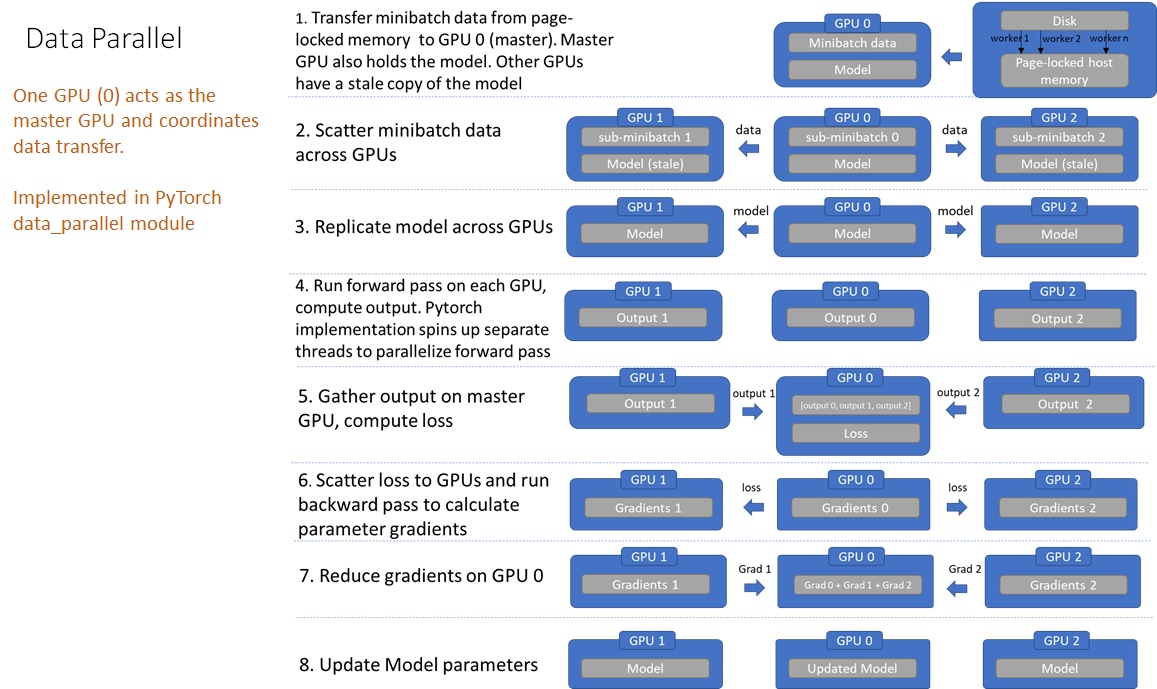
* 复制(Replicate)：将模型拷贝到多个 GPU 上；

* 分发(Scatter)：将输入数据根据其第一个维度(通常就是 batch 大小)划分多份，并传送到多个 GPU 上；

* 收集(Gather)：从多个 GPU 上传送回来的数据，再次连接回一起；

* 并行的应用(parallel_apply)：将第三步得到的分布式的输入数据应用到第一步中拷贝的多个模型上。

In [ ]:
# 多个GPU来加速训练，pytorch接口
device_ids = [0, 1]  # id为0和1的两块显卡
model = torch.nn.DataParallel(model, device_ids=device_ids)

In [ ]:
# 终端执行，查看显卡占用信息
watch -n 1 nvidia-smi 

**官方文档，参数解读**
* CLASS torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
    * module – 要被并行的module
    * device_ids – CUDA设备，默认为所有设备。
    * output_device – 输出设备（默认为device_ids[0]）
    * dim - 所有的变量会通过指定的dim来划分（默认值为0）


In [ ]:
# 模型初始化错误需要指定：
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5,6,7"

常见问题
*UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; 
will instead unsqueeze and return a vector.*

In [1]:
# 具体例子
import torch
from torch import nn
import dltools

In [ ]:
# 定义模型
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(dltools.Residual(in_channels, out_channels,use_1x1conv=True, strides=2))
            else:
                blk.append(dltools.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),nn.Linear(512, num_classes)))
    return net

In [ ]:
# 网络初始化
net = resnet18(10)
# 获取GPU列表
devices = dltools.try_all_gpus()
# 我们将在训练代码实现中初始化网络

In [ ]:
# 训练
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = dltools.load_data_fashion_mnist(batch_size)
    devices = [dltools.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices)# 
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = dltools.Timer(), 10
    animator = dltools.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (dltools.evaluate_accuracy_gpu(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'f'在{str(devices)}')

In [ ]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

测试精度：0.92，14.0秒/轮，在[device(type='cuda', index=0)]
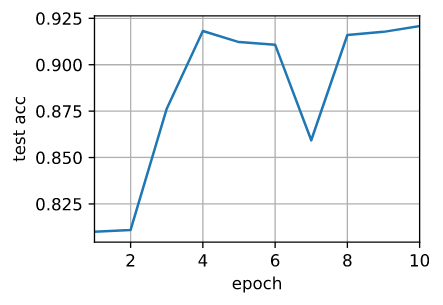

In [ ]:
train(net, num_gpus=2, batch_size=512, lr=0.2)

测试精度：0.72，9.3秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]
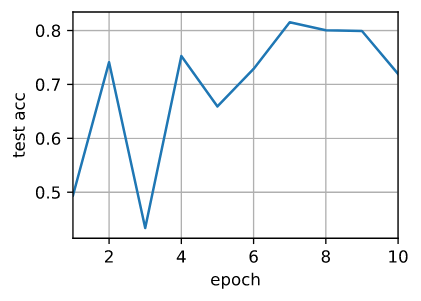